In [1]:
import pandas as pd
import pgaccess as pg

Do bigger delays lead to more fuel consumed per passenger?

This one will be based on the average monthly delay per carrier, and the average distance covered per month for a carrier. Then take the number of passengers those carriers carried in a month. Finally including the fuel comsumption per carrier.

The final number we'd be looking for will be the average fuel consumption per passenger per km. How does that number change with average delay for a carrier.

In [3]:
# Find the montly delay and distance per carrier
monthly = pg.execute_query("""
SELECT
    EXTRACT(MONTH FROM TO_DATE(fl_date, 'YYYY-MM-DD')) AS "month",
    op_unique_carrier,
    SUM(arr_delay) AS delay,
    SUM(distance) AS distance
FROM flights
GROUP BY "month", op_unique_carrier
""")
monthly['month'] = monthly.month.astype(int)
monthly

,month,op_unique_carrier,delay,distance
0,1.0,9E,141322.0,17667250.0
1,1.0,9K,-903.0,39990.0
2,1.0,AA,278043.0,149984729.0
3,1.0,AS,-97546.0,46112528.0
4,1.0,AX,237809.0,5997313.0
...,...,...,...,...
315,12.0,UA,603188.0,124932262.0
316,12.0,WN,989092.0,171519740.0
317,12.0,YV,483559.0,21522896.0
318,12.0,YX,201806.0,32722366.0


In [6]:
# Take the average across the months
monthly_agg = monthly.groupby('op_unique_carrier').agg({
    'delay': 'mean',
    'distance': 'mean'
})
monthly_agg

,delay,distance
op_unique_carrier,,
9E,154395.333333,1.965672e+07
9K,-468.000000,3.895800e+04
AA,943667.916667,1.558355e+08
AS,19238.750000,5.575951e+07
AX,198731.166667,6.078678e+06
B6,557459.583333,5.467669e+07
C5,194661.916667,3.229388e+06
CP,90944.083333,8.655825e+06
DL,74846.333333,1.441976e+08


Good on you 9K for being the only carrier who is actually generally early each month

---

Next we'll look for how many passengers each carrier generally carries in a month.

It seems the passengers table has a much bigger list of available carriers than the flights table. I'm not sure what's up with all the other carriers. If anything I would have expected the flights table to be the larger one, with the thinking that there could be flights or carriers that don't take passengers.  
But even with the extra carriers it does seem all the flights carriers are accounted for. So I'll just disregard the extra carriers for now and work just with those on the above list.

In [13]:
codes = "', '".join(monthly_agg.index)
# SQL injection can suck it
passenger_counts = pg.execute_query(f'''
SELECT
    passengers.month,
    unique_carrier,
    SUM(passengers.passengers) AS passengers
FROM passengers
WHERE unique_carrier IN ('{codes}')
GROUP BY passengers.month, unique_carrier
''')
passenger_counts

,month,unique_carrier,passengers
0,1,9E,4108407.0
1,1,9K,214781.0
2,1,AA,52674163.0
3,1,AS,10097644.0
4,1,AX,1164611.0
...,...,...,...
331,12,VX,2047823.0
332,12,WN,68233418.0
333,12,YV,5736688.0
334,12,YX,6862118.0


In [14]:
monthly_pass = passenger_counts.groupby('unique_carrier').agg({
    'passengers': 'mean'
})
monthly_pass

,passengers
unique_carrier,
9E,5.166351e+06
9K,2.497884e+05
AA,5.960032e+07
AS,1.210084e+07
AX,1.369472e+06
B6,1.657267e+07
C5,6.895835e+05
CP,2.522472e+06
DL,6.187595e+07


In [16]:
monthly_agg['passengers'] = monthly_pass['passengers']
monthly_agg.head()

,delay,distance,passengers
op_unique_carrier,,,
9E,154395.333333,1.965672e+07,5.166351e+06
9K,-468.000000,3.895800e+04,2.497884e+05
AA,943667.916667,1.558355e+08,5.960032e+07
AS,19238.750000,5.575951e+07,1.210084e+07
AX,198731.166667,6.078678e+06,1.369472e+06


Last up is fuel consumption per month  
Or, excuse me, fuel _comsumption_, my mistake

Again, as before, there appear to me more airlines here than appeared in the flights list. I'll disregard any airlines that aren't in the original list

In [52]:
codes = "', '".join(monthly_agg.index)
fuel = pg.execute_query(f'''
SELECT
    fuel.month,
    unique_carrier,
    SUM(total_gallons) AS total_gallons
FROM fuel_comsumption fuel
WHERE unique_carrier IN ('{codes}')
GROUP BY fuel.month, unique_carrier
''')
fuel

,month,unique_carrier,total_gallons
0,3,CP,0.0
1,3,HA,105119869.0
2,8,9E,0.0
3,1,YV,0.0
4,11,9E,0.0
...,...,...,...
259,7,ZW,13590518.0
260,5,G4,73447966.0
261,9,VX,46940511.0
262,11,AS,173532573.0


The row count is higher, that seems to be mainly because this table includes as far back as 2016, while the other tables are 2018 onwards

It also occurs to me here that I could have aggregated on the db, seeing as the table is already summed per month. But again, oh well

In [53]:
monthly_fuel = fuel.groupby('unique_carrier').agg({
    'total_gallons': 'mean'
})
monthly_fuel

,total_gallons
unique_carrier,
9E,0.000000e+00
AA,1.386241e+09
AS,2.232046e+08
B6,3.139216e+08
CP,0.000000e+00
DL,1.379188e+09
EV,2.231869e+05
F9,9.377454e+07
G4,7.081350e+07


Now there's a small problem where the fuel consumed actually doesn't have values for all the carriers from flights.  
In this case I'll just look at carriers that do have that information, depending on those results an attempt can be made later to extrapolate the other carriers' values.

In [54]:
all_agg = pd.merge(
    monthly_agg, monthly_fuel,
    left_index = True,
    right_index = True
)
all_agg = all_agg[all_agg['total_gallons'] > 0]
all_agg

,delay,distance,passengers,total_gallons
AA,943667.916667,1.558355e+08,5.960032e+07,1.386241e+09
AS,19238.750000,5.575951e+07,1.210084e+07,2.232046e+08
B6,557459.583333,5.467669e+07,1.657267e+07,3.139216e+08
DL,74846.333333,1.441976e+08,6.187595e+07,1.379188e+09
EV,310294.000000,1.303293e+07,6.594632e+06,2.231869e+05
F9,235844.416667,2.198570e+07,7.313943e+06,9.377454e+07
G4,148873.666667,1.469276e+07,5.177141e+06,7.081350e+07
HA,10413.083333,9.977829e+06,4.648382e+06,1.011299e+08
NK,160478.666667,3.199132e+07,1.062746e+07,1.386090e+08
OO,940596.083333,6.517615e+07,1.490407e+07,3.180867e+07


Now we have all the required values, we can start putting them together to calculate the desired metric.  
We want the fuel per passenger per km, then we can compare that to the delay

It's probably worth mentioning that the data is actually in miles. But the actual number shouldn't matter, so if we just pretend we're using real units instead the result _should_ be the same.

In [55]:
all_agg['fuel_per_passengerkm'] = all_agg.total_gallons / all_agg.passengers / all_agg.distance
all_agg

,delay,distance,passengers,total_gallons,fuel_per_passengerkm
AA,943667.916667,1.558355e+08,5.960032e+07,1.386241e+09,1.492532e-07
AS,19238.750000,5.575951e+07,1.210084e+07,2.232046e+08,3.308025e-07
B6,557459.583333,5.467669e+07,1.657267e+07,3.139216e+08,3.464388e-07
DL,74846.333333,1.441976e+08,6.187595e+07,1.379188e+09,1.545765e-07
EV,310294.000000,1.303293e+07,6.594632e+06,2.231869e+05,2.596786e-09
F9,235844.416667,2.198570e+07,7.313943e+06,9.377454e+07,5.831673e-07
G4,148873.666667,1.469276e+07,5.177141e+06,7.081350e+07,9.309423e-07
HA,10413.083333,9.977829e+06,4.648382e+06,1.011299e+08,2.180427e-06
NK,160478.666667,3.199132e+07,1.062746e+07,1.386090e+08,4.076895e-07
OO,940596.083333,6.517615e+07,1.490407e+07,3.180867e+07,3.274552e-08


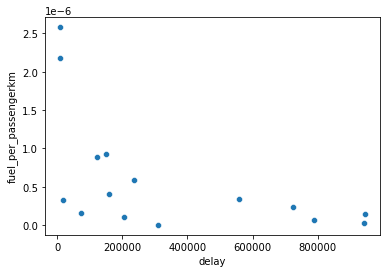

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=all_agg, x='delay', y='fuel_per_passengerkm')
plt.show()

Admittedly there aren't many data points here. But intuitively I would suggest the relation ship is positive, ie more delay means more fuel per passenger per unit distance. The chart is showing either that's backwards, or those couple of points are just there and fuel consumption is basically constant regardless of the delay.

If there were a more distinct relationship we probably could have tried estimating the fuel usage for the missing carriers. But given there's nothing really here to work with, trying to add values would probably only show us the values that we added.

### Comparing same carrier month-over-month

The next question that arises here is that, maybe the carriers are different enough from each other that we're only seeing carrier habits. Maybe there is a relationship there but it's not as influential as just how the carrier tends to handle other contributing factors.

Lets look at whether the numbers for a single carrier change between months.

In [65]:
new_agg = pd.merge(
    monthly, passenger_counts,
    left_on = ['month', 'op_unique_carrier'],
    right_on = ['month', 'unique_carrier']
).drop(columns='op_unique_carrier')
new_agg

,month,delay,distance,unique_carrier,passengers
0,1,141322.0,17667250.0,9E,4108407.0
1,1,-903.0,39990.0,9K,214781.0
2,1,278043.0,149984729.0,AA,52674163.0
3,1,-97546.0,46112528.0,AS,10097644.0
4,1,237809.0,5997313.0,AX,1164611.0
...,...,...,...,...,...
315,12,603188.0,124932262.0,UA,44826607.0
316,12,989092.0,171519740.0,WN,68233418.0
317,12,483559.0,21522896.0,YV,5736688.0
318,12,201806.0,32722366.0,YX,6862118.0


In [66]:
new_agg = pd.merge(new_agg, fuel)
new_agg = new_agg[new_agg.total_gallons > 0]
new_agg

,month,delay,distance,unique_carrier,passengers,total_gallons
1,1,278043.0,149984729.0,AA,52674163.0,1.334803e+09
2,1,-97546.0,46112528.0,AS,10097644.0,2.269071e+08
3,1,689687.0,52116552.0,B6,15358093.0,3.180274e+08
5,1,-207386.0,128022828.0,DL,52153958.0,1.314128e+09
6,1,316201.0,14820044.0,EV,6646982.0,2.716850e+05
...,...,...,...,...,...,...
248,12,1020500.0,67971369.0,OO,14928480.0,2.675310e+07
250,12,603188.0,124932262.0,UA,44826607.0,1.100734e+09
251,12,989092.0,171519740.0,WN,68233418.0,6.800387e+08
253,12,201806.0,32722366.0,YX,6862118.0,1.301998e+07


In [67]:
# Get rid of 0 fuel used
new_agg['fuel_per_passengerkm'] = new_agg.total_gallons\
                                / new_agg.passengers\
                                / new_agg.distance
new_agg

,month,delay,distance,unique_carrier,passengers,total_gallons,fuel_per_passengerkm
1,1,278043.0,149984729.0,AA,52674163.0,1.334803e+09,1.689555e-07
2,1,-97546.0,46112528.0,AS,10097644.0,2.269071e+08,4.873142e-07
3,1,689687.0,52116552.0,B6,15358093.0,3.180274e+08,3.973302e-07
5,1,-207386.0,128022828.0,DL,52153958.0,1.314128e+09,1.968171e-07
6,1,316201.0,14820044.0,EV,6646982.0,2.716850e+05,2.757984e-09
...,...,...,...,...,...,...,...
248,12,1020500.0,67971369.0,OO,14928480.0,2.675310e+07,2.636529e-08
250,12,603188.0,124932262.0,UA,44826607.0,1.100734e+09,1.965495e-07
251,12,989092.0,171519740.0,WN,68233418.0,6.800387e+08,5.810619e-08
253,12,201806.0,32722366.0,YX,6862118.0,1.301998e+07,5.798390e-08


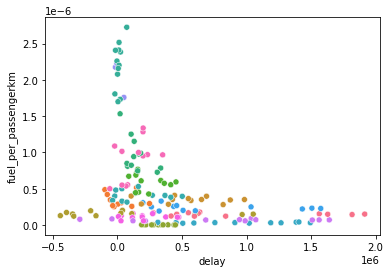

In [69]:
# Plot
sns.scatterplot(
    data = monthOverMonth,
    x = 'delay',
    y = 'fuel_per_passengerkm',
    hue = 'unique_carrier',
    legend = False
)
plt.show()

Again, there isn't really a clear relationship. There's a large spike around 0 from two carriers that just can't figure out how much fuel to use. Most other carriers seem to be mostly about the same fuel consumption regardless of their delay.